In [444]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import operator
import os

In [445]:
OUTPUT_DIR = "./plot_builder_output"
os.makedirs(f"{OUTPUT_DIR}/heatmaps", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/lineplot", exist_ok=True)

In [446]:
def make_heatmap(results : dict, our_results : dict, title : str, baseline : str, minimizing = True, add_whole_family_value = True):
    values = np.array([list(item[-2].values()) for train, item in results.items()]).squeeze(axis=-1)
    values[~np.isfinite(values)] = np.nan
    # if add_whole_family_value:
        # entire_family_values = np.array([item[-1] for train, item in results.items()])
        # values = np.hstack([values, entire_family_values[..., None]])
    values = np.vstack([values, our_results['ours']])
    if add_whole_family_value:
        entire_family_values = np.array([item[-1] if item[-1] is not None else np.nan for train, item in results.items()] + [our_results['whole_family']])
        # entire_family_values[~np.isfinite(entire_family_values)] = np.nan
        values = np.hstack([values, entire_family_values[..., None]])
    plt.figure(figsize=(16,9))
    
    ax = sns.heatmap(values, annot=True, vmin=np.nanmin(values), vmax=np.nanmax(values), cmap=sns.cm.rocket_r if minimizing else sns.cm.rocket, mask=~np.isfinite(values), fmt='.2f')
    
    # if add_whole_family_value:
        # ax.add_patch(Rectangle((0,0), 10, 11, fill=False, edgecolor='white', lw=3)) # White bounding box
    
    
    best_value = np.inf if minimizing else -np.inf
    for r in range(values.shape[0]):
        row_values = values[r][:-1] if add_whole_family_value else values[r]
        idx = np.nanargmax(row_values) if minimizing else np.nanargmin(row_values)
        cmp = operator.le if minimizing else operator.ge
        if cmp(row_values[idx], best_value):
            best_value = row_values[idx]
            best_rectangle = (idx, r)
        ax.add_patch(Rectangle((idx, r),1,1, fill=False, edgecolor='blue', lw=3))
    ax.add_patch(Rectangle(best_rectangle,1,1, fill=False, edgecolor='green', lw=3))
    
    if add_whole_family_value:
        best_family_idx = np.nanargmin(values[:, -1]) if minimizing else np.nanargmax(values[:, -1])
        ax.add_patch(Rectangle((10, best_family_idx),1,1, fill=False, edgecolor='green', lw=3))
    
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")
    plt.yticks(rotation=0) 
    xticks = [f"{i}" for i in range(10)]
    if add_whole_family_value:
        xticks += ["Entire family"]
    ax.set_xticklabels(xticks) 
    ax.set_yticklabels([f"{baseline} on {i}" for i in range(10)] + ["Ours: GD on (sub)family"])
    ax.set_title(f"{title}: {baseline} vs Ours ({'lower' if minimizing else 'higher'} is better)")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/heatmaps/{title}-{baseline}.png")

In [447]:
def make_lineplot(results : dict, title : str = 'Placeholder', minimizing = True, type_of_plot = 'family_trace'):
    plt.figure()
    plt.title(f"{title} ({'lower' if minimizing else 'higher'} is better)")
    plt.xlabel("Iteration")
    plt.ylabel("Worst family member value")
    plt.plot(results['gd-normal'][type_of_plot], label='Paynt GD')
    plt.plot(results['gd-no-momentum'][type_of_plot], label='Paynt GD (no momentum)')
    plt.plot(results['gd-random'][type_of_plot], label='Random GD')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/lineplot/{title}.png")

[Errno 2] No such file or directory: 'outputs/avoid/gd-experiment.pickle'


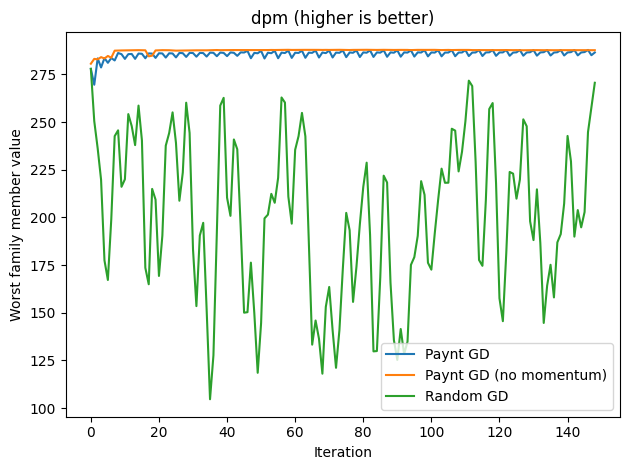

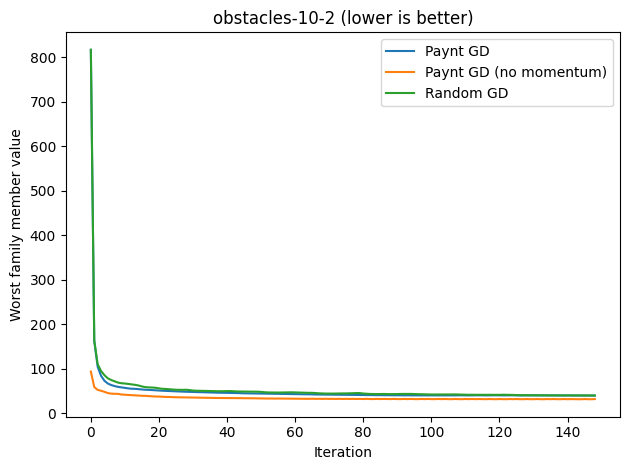

In [448]:
for env in ['dpm', 'obstacles-10-2', 'avoid']:
    try:
        with open(f"outputs/{env}/gd-experiment.pickle", 'rb') as handle:
            results = pickle.load(handle)
            make_lineplot(results, title=env, minimizing='dpm' not in env.lower())
    except FileNotFoundError as fnfe:
        print(fnfe)

# DPM

timeout = 10s

In [449]:
dpm_our = [504.76099479, 496.6463078,  522.29707964, 471.26597349, 483.96767624,
 463.09737765, 294.67001291, 498.28841493, 510.35243059, 509.71750883]

In [450]:
with open("outputs/dpm/10/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [451]:
with open("outputs/dpm/10/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [452]:
with open("outputs/dpm/10/gd.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [453]:
values = np.array([list(item[-2].values()) for train, item in subfamily_gd_results.items()]).squeeze(axis=-1)
values[~np.isfinite(values)] = np.nan
values = np.vstack([values, dpm_our])
entire_family_values = np.array([item[-1] for train, item in subfamily_gd_results.items()] + [np.nan])
values = np.hstack([values, entire_family_values[:, None]])

In [454]:
values.shape, entire_family_values.shape

((11, 11), (11,))

In [455]:
ours

{'ours': array([501.43201274, 495.57526291, 520.94980303, 471.93196525,
        484.50302646, 464.69817836, 293.25817419, 496.20957088,
        509.10724826, 510.00162779]),
 'whole_family': 287.29654902664026}

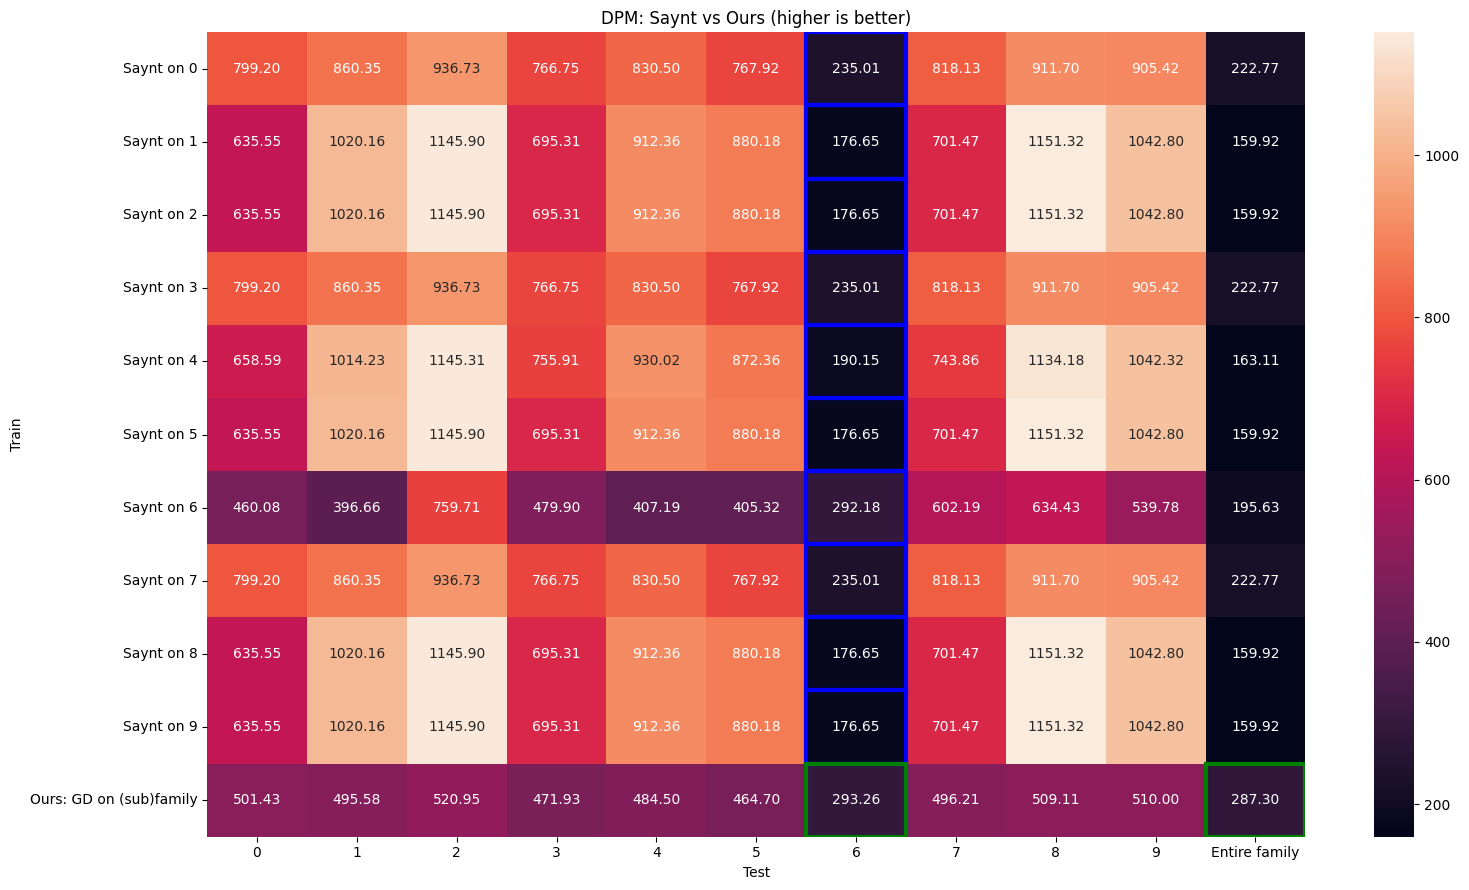

In [456]:
make_heatmap(subfamily_saynt_results, ours, "DPM", "Saynt", minimizing=False)

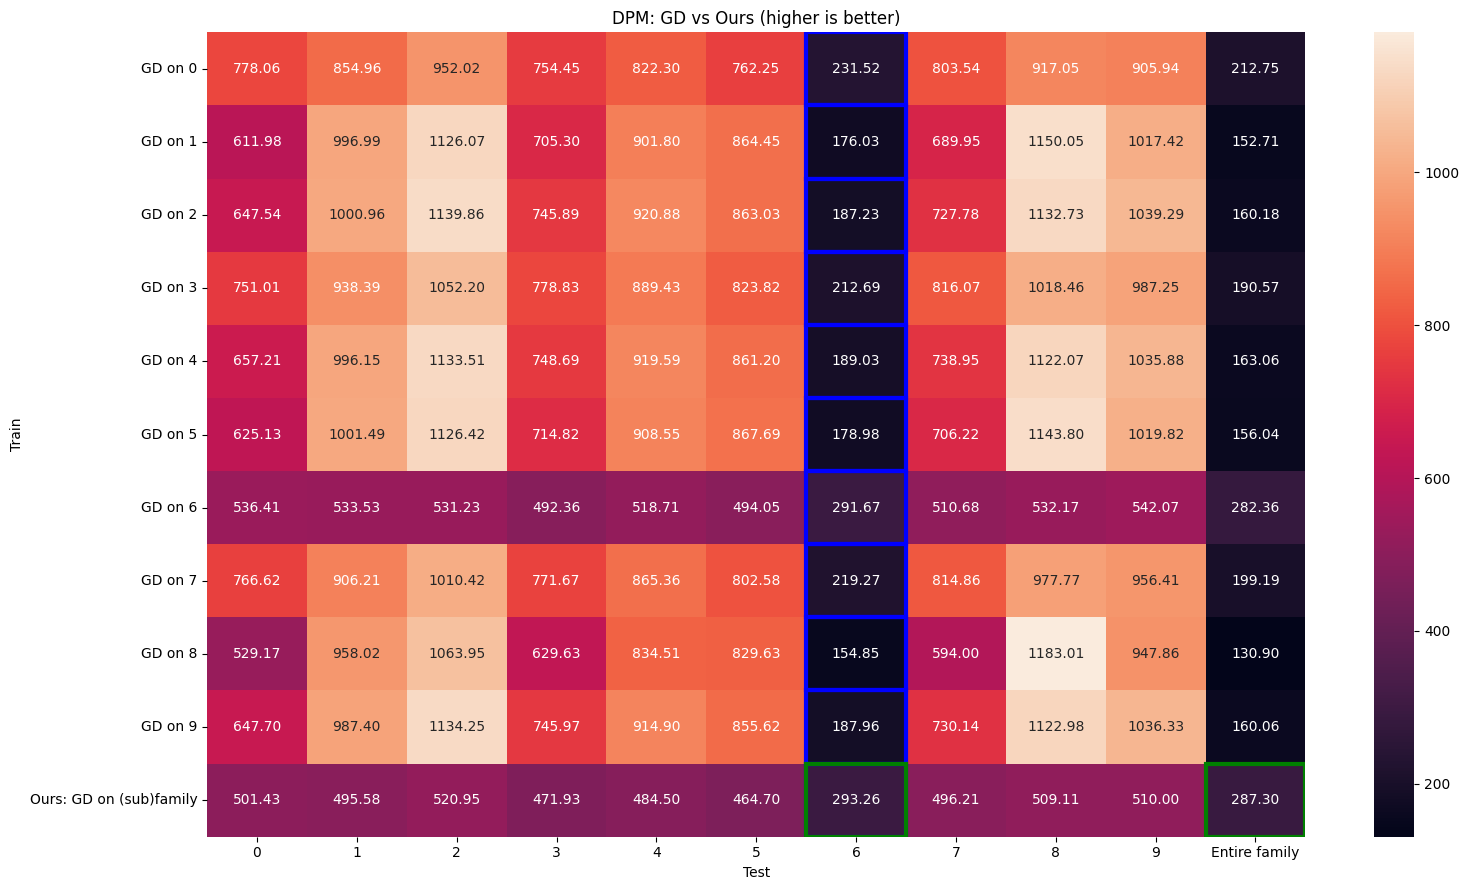

In [457]:
make_heatmap(subfamily_gd_results, ours, "DPM", "GD", minimizing=False)

# OBSTACLES 8 3

timeout = 30s

In [458]:
with open("outputs/obstacles-8-3/10/saynt.pickle", 'rb') as handle:
    saynt = pickle.load(handle)

In [459]:
with open("outputs/obstacles-8-3/10/gradient.pickle", 'rb') as handle:
    gradient = pickle.load(handle)

In [460]:
with open("outputs/obstacles-8-3/10/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

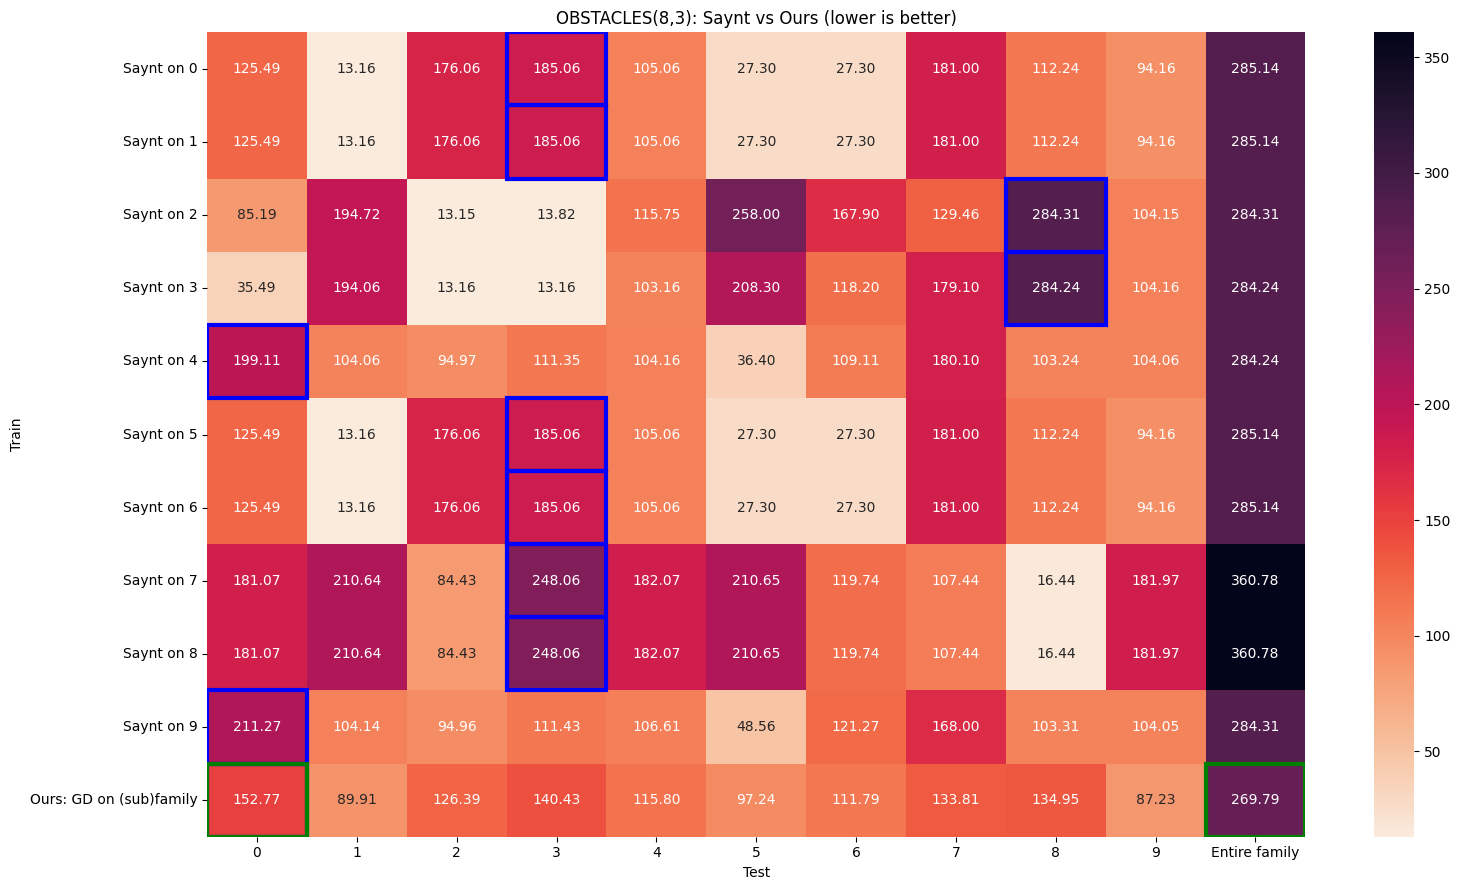

In [461]:
make_heatmap(saynt, ours, "OBSTACLES(8,3)", "Saynt")

## Gradient baseline

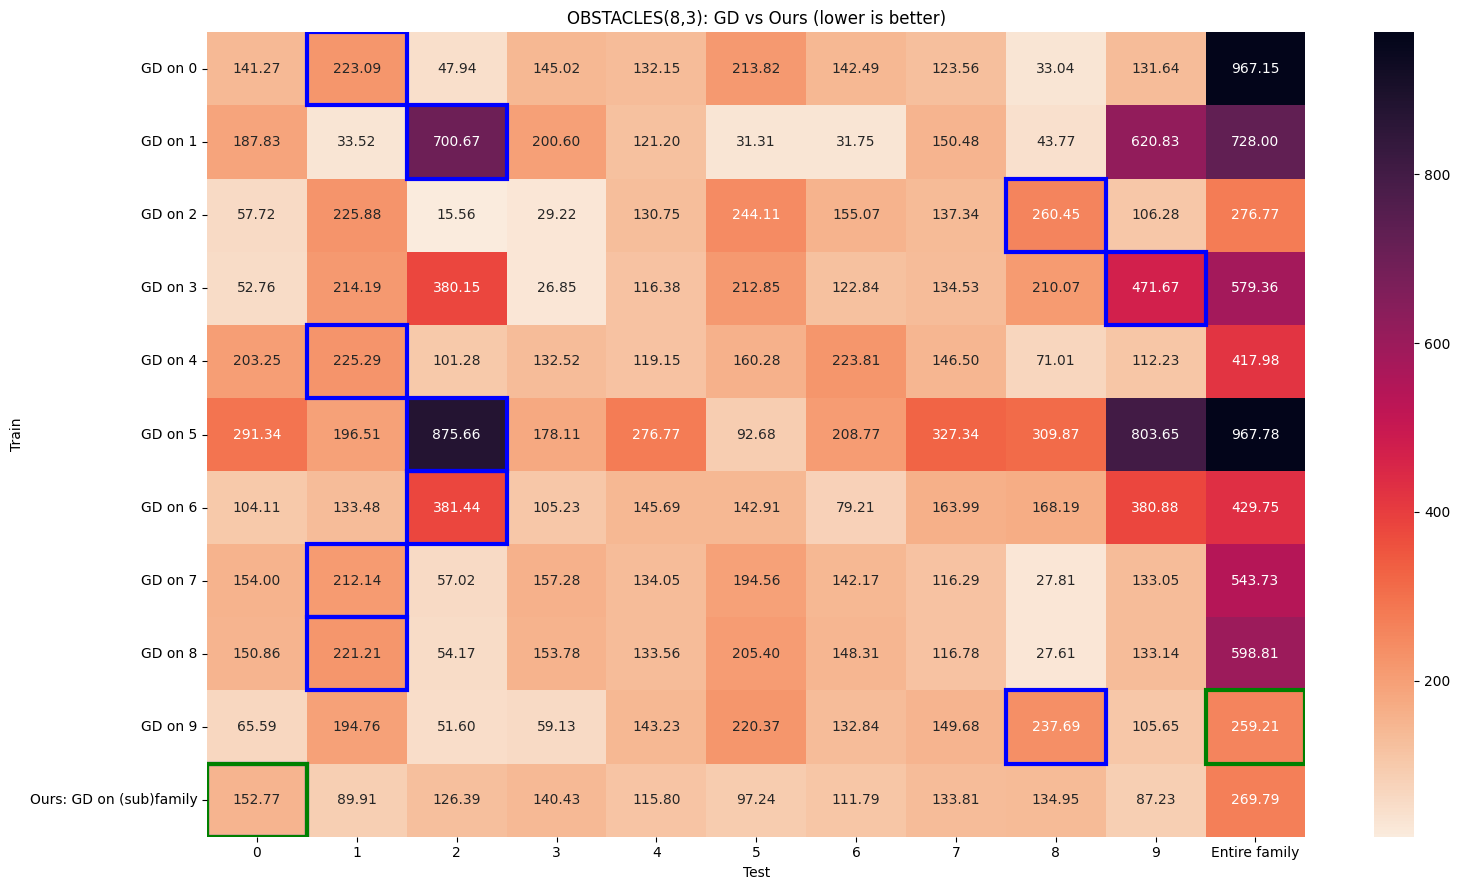

In [462]:
make_heatmap(gradient, ours, "OBSTACLES(8,3)", "GD")

# OBSTACLES 10 2

timeout = 10s

In [463]:
with open("outputs/obstacles-10-2/10/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [464]:
with open("outputs/obstacles-10-2/10/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [465]:
with open("outputs/obstacles-10-2/10/gd.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [466]:
ours_raw = [27.85853738, 28.71888006, 30.78940948, 28.75065993, 29.3297606,  30.77959397,
 29.48840814, 29.3297606,  28.22878829, 30.14997737]

In [467]:
ours

{'ours': array([29.71332153, 34.75044441, 34.78858378, 28.91082002, 29.31422517,
        34.66742393, 29.53309369, 29.31422517, 30.3172947 , 34.80426136]),
 'whole_family': 43.10328317207831}

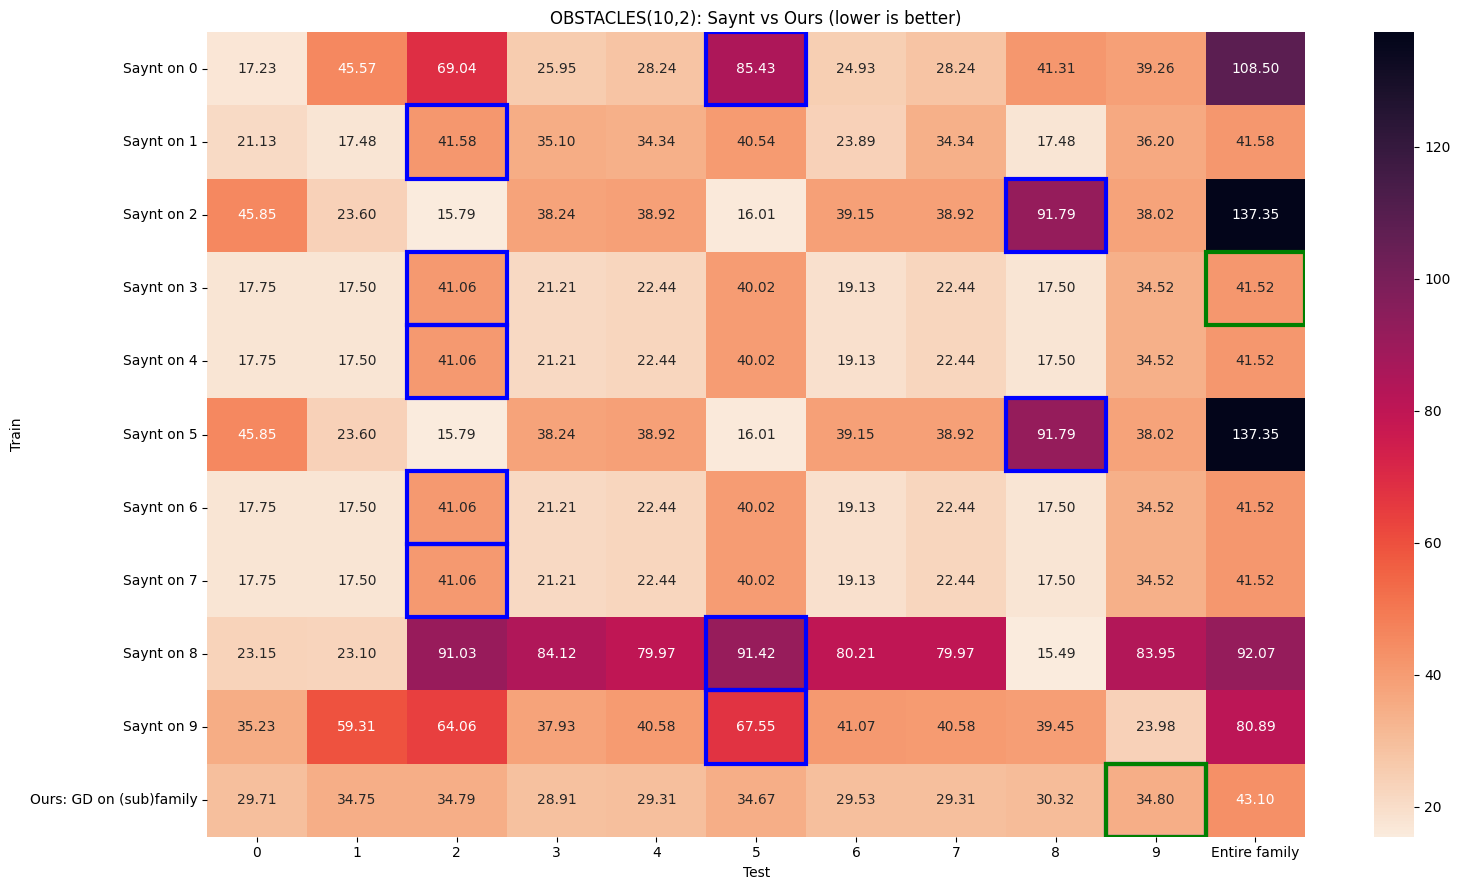

In [468]:
make_heatmap(subfamily_saynt_results, ours, "OBSTACLES(10,2)", "Saynt")

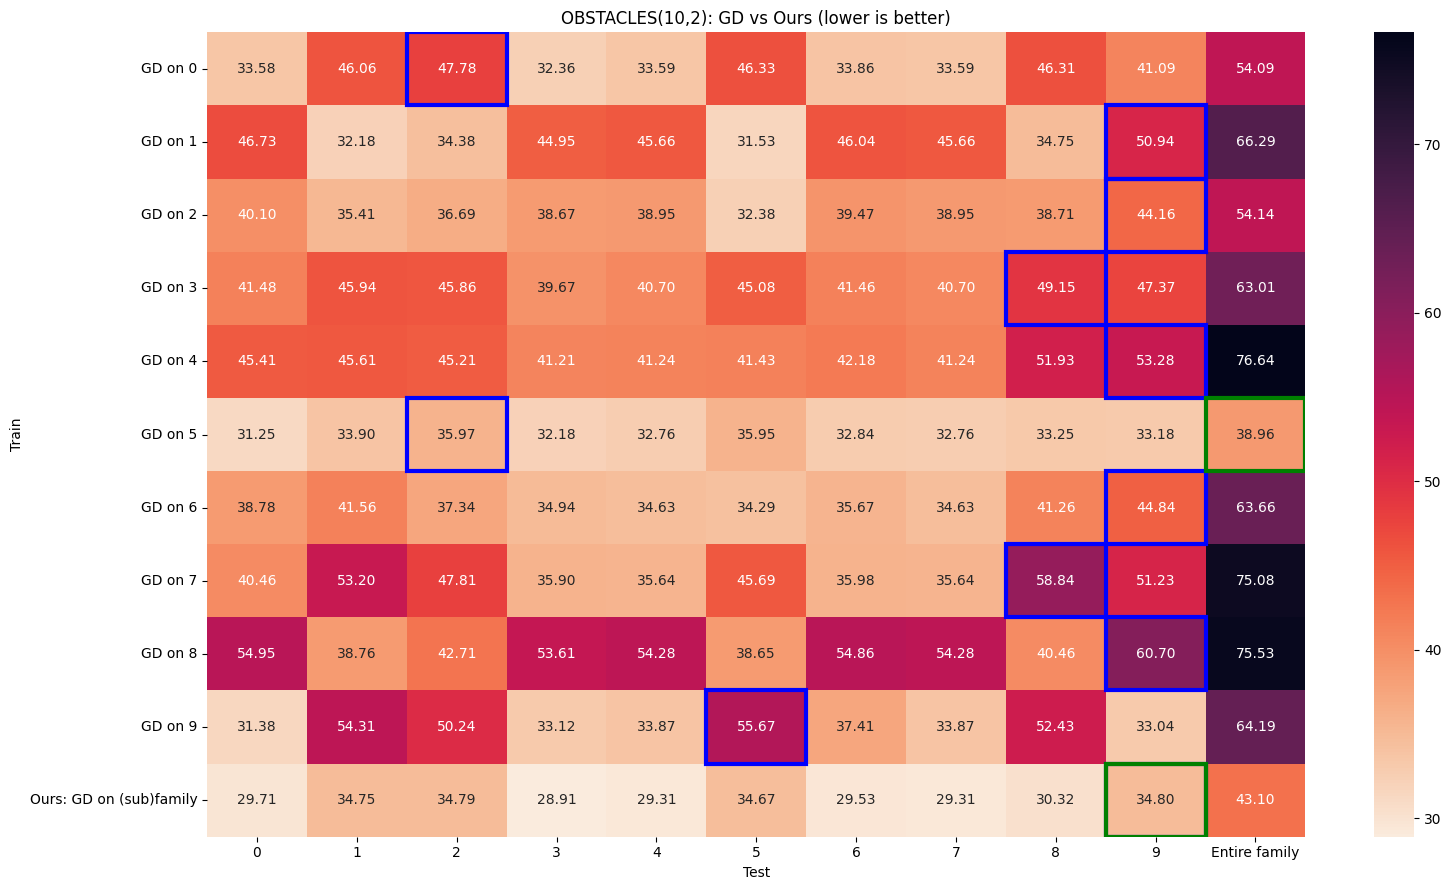

In [469]:
make_heatmap(subfamily_gd_results, ours, "OBSTACLES(10,2)", "GD")

# AVOID

timeout = 60s

In [470]:
with open("outputs/avoid/10/ours.pickle", 'rb') as handle:
    ours = pickle.load(handle)

In [471]:
ours

{'ours': array([80.86308042, 69.84679096, 57.64285018, 79.21669863, 63.29178246,
        65.26238688, 80.07232592, 66.57724146, 76.42203023, 62.8002326 ]),
 'whole_family': 166.60389407163706}

In [472]:
with open("outputs/avoid/10/paynt.pickle", 'rb') as handle:
    subfamily_paynt_results = pickle.load(handle)

In [473]:
with open("outputs/avoid/10/gd.pickle", 'rb') as handle:
    subfamily_gd_results = pickle.load(handle)

In [474]:
with open("outputs/avoid/10/saynt.pickle", 'rb') as handle:
    subfamily_saynt_results = pickle.load(handle)

In [475]:
l = [51.94674404, 65.42364497, 63.76348781, 98.68745545, 32.52550974, 67.09607064,
 87.41523619, 64.81453459, 53.95332456, 56.50783793]

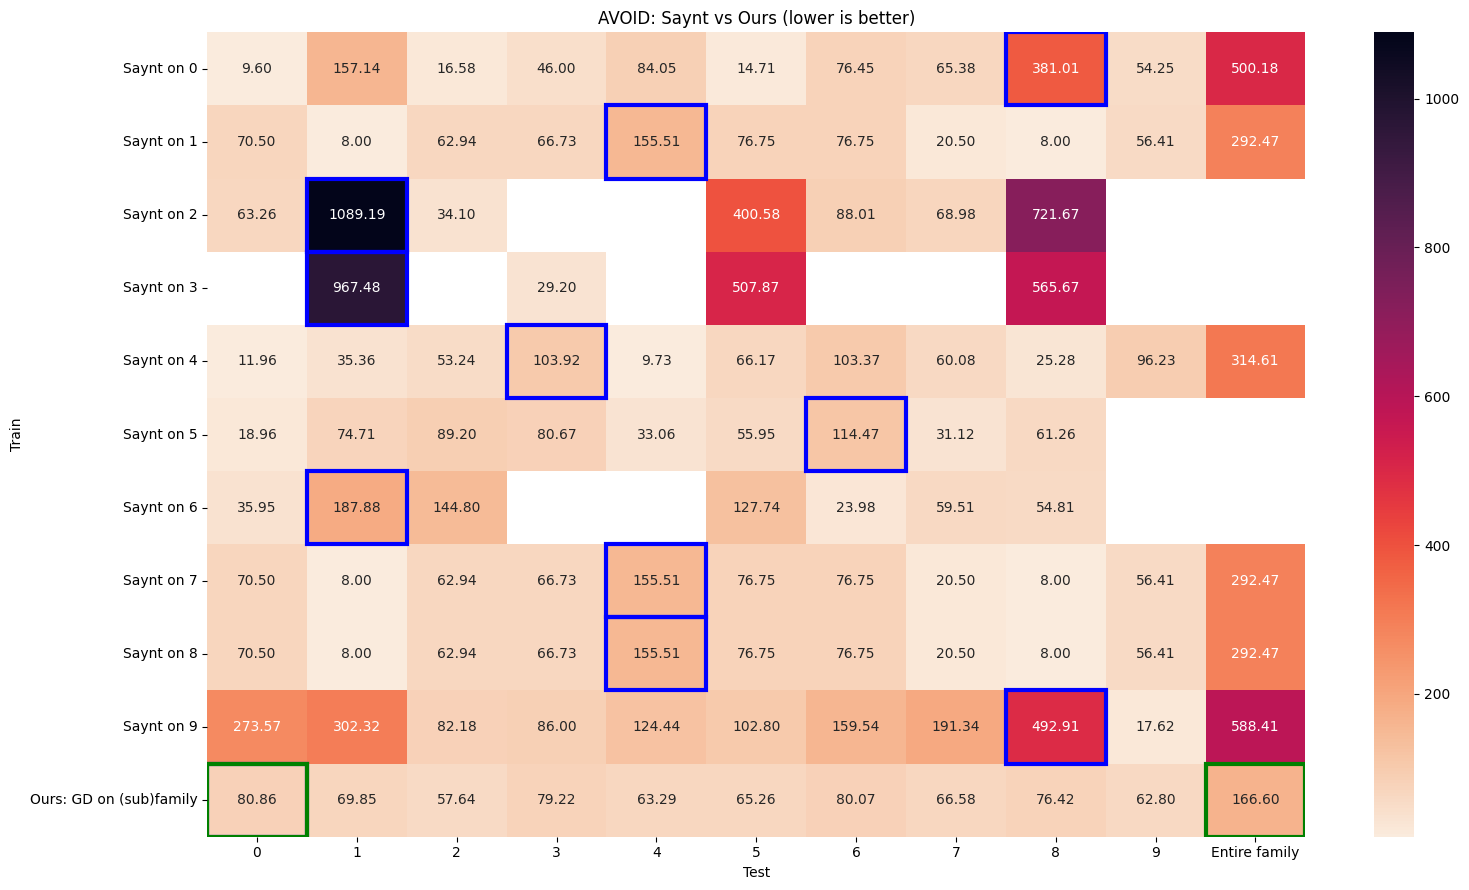

In [476]:
make_heatmap(subfamily_saynt_results, ours, "AVOID", "Saynt")

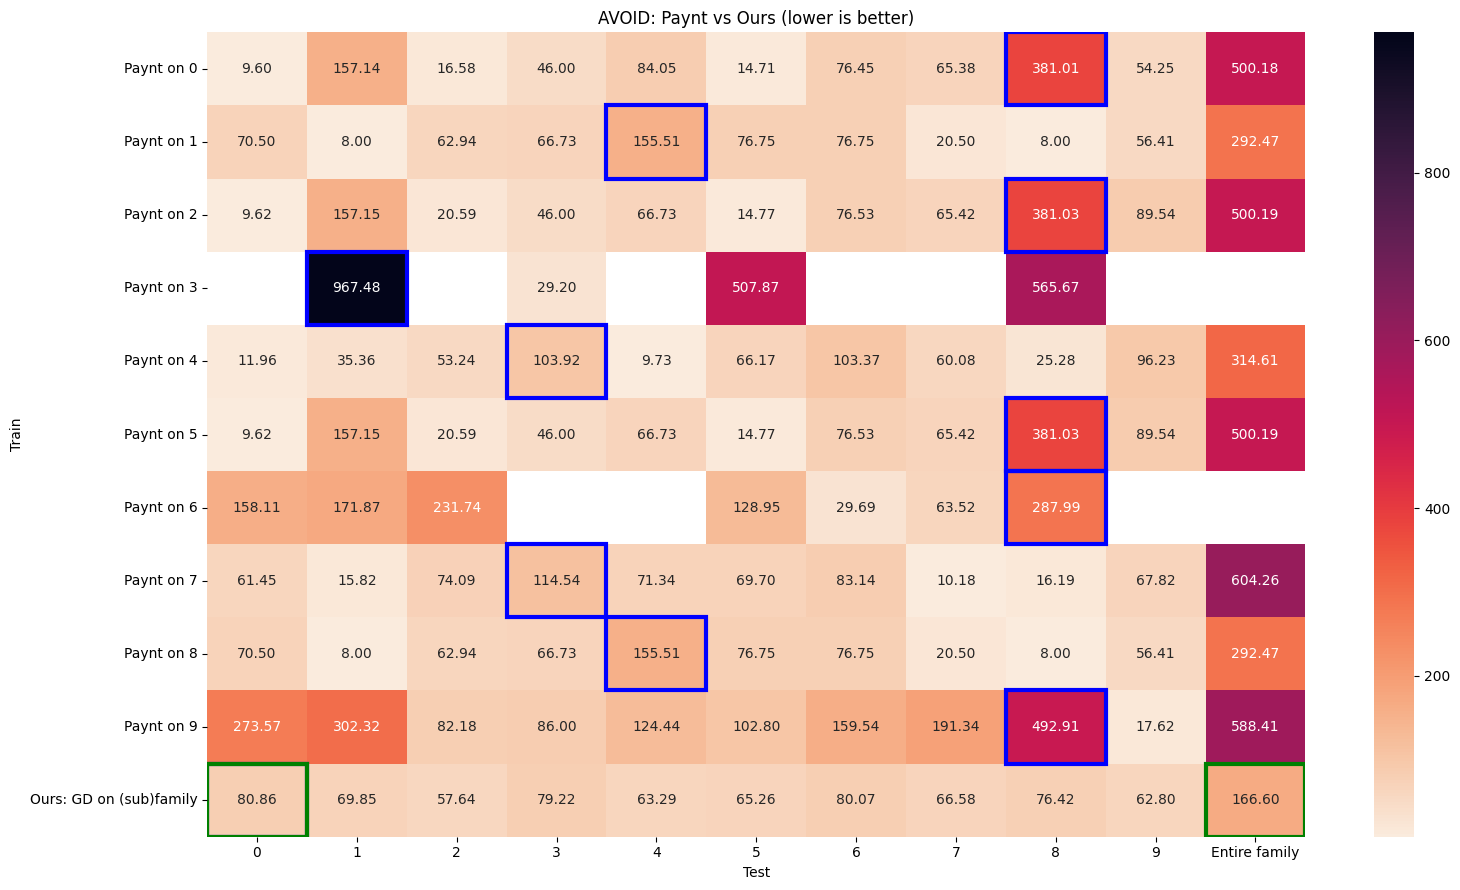

In [477]:
make_heatmap(subfamily_paynt_results, ours, "AVOID", "Paynt")

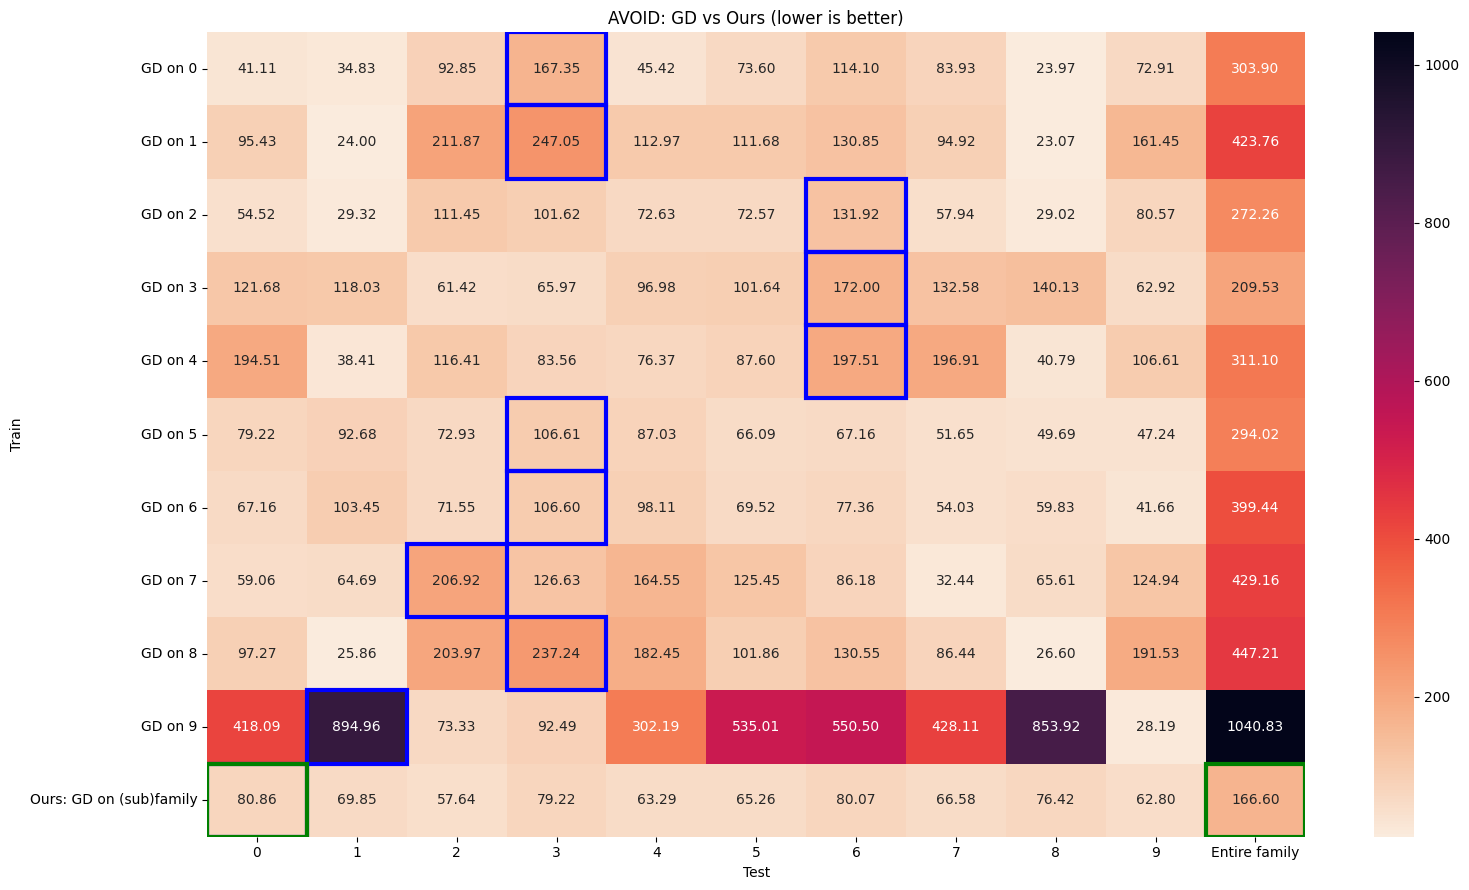

In [478]:
make_heatmap(subfamily_gd_results, ours, "AVOID", "GD")